<a href="https://colab.research.google.com/github/Jude-Morgan/Machine-Learning-projects/blob/main/ComputerVision_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
!pip install optuna
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision import transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision.datasets import CIFAR10

dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transforms, download=True)

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Split train dataset into train and validation sets
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

100%|██████████| 170498071/170498071 [00:03<00:00, 46322539.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN()
model = model.to(device=device)
print(device)

cuda:0


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Epoch [1/20], Training Loss: 2.1820, Training Acc: 16.6600, Val Loss: 2.2119, Validation Acc: 25.8900
Epoch [2/20], Training Loss: 1.8508, Training Acc: 27.3075, Val Loss: 2.1407, Validation Acc: 29.2300
Epoch [3/20], Training Loss: 2.1014, Training Acc: 31.6350, Val Loss: 1.5912, Validation Acc: 33.0400
Epoch [4/20], Training Loss: 1.7072, Training Acc: 35.2325, Val Loss: 1.8620, Validation Acc: 36.0300
Epoch [5/20], Training Loss: 2.0153, Training Acc: 37.8850, Val Loss: 1.8365, Validation Acc: 37.9900
Epoch [6/20], Training Loss: 1.8635, Training Acc: 40.0250, Val Loss: 1.6287, Validation Acc: 40.1800
Epoch [7/20], Training Loss: 1.5622, Training Acc: 41.8325, Val Loss: 1.5089, Validation Acc: 42.4900
Epoch [8/20], Training Loss: 1.5286, Training Acc: 43.7200, Val Loss: 1.6389, Validation Acc: 43.8700
Epoch [9/20], Training Loss: 1.3143, Training Acc: 45.1075, Val Loss: 2.1415, Validation Acc: 45.9000
Epoch [10/20], Training Loss: 1.5655, Training Acc: 46.7725, Val Loss: 1.6341, Val

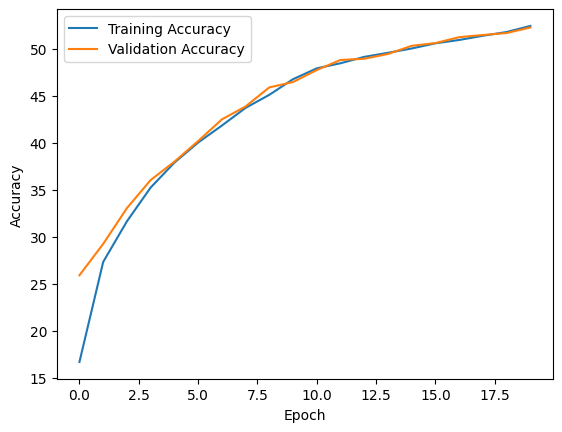

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc.append(100 * train_correct / train_total)

        scheduler.step()

        model.eval()
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_acc.append(100 * valid_correct / valid_total)

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Acc: {:.4f}, Val Loss: {:.4f}, Validation Acc: {:.4f}'
              .format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))

    return train_loss, train_acc, valid_loss, valid_acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
gamma = 0.5
step_size = 10
num_epochs = 20  # Define the number of epochs

model = CNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs)

plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def objective(learning_rate, scheduler_name, step_size=None, gamma=None):
    model = CNN().to(device=device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if scheduler_name == 'StepLR':
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc.append(100 * train_correct / train_total)

        if scheduler_name == 'StepLR':
            scheduler.step()

        model.eval()
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_acc.append(100 * valid_correct / valid_total)

    return valid_acc[-1]  # Return last validation accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
num_epochs = 50

learning_rate = 0.01
scheduler_name = 'StepLR'
step_size = 10
gamma = 0.5

model = CNN().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

if scheduler_name == 'StepLR':
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc.append(100 * train_correct / train_total)

    if scheduler_name == 'StepLR':
        scheduler.step()

    model.eval()
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_acc.append(100 * valid_correct / valid_total)

    if scheduler_name != 'StepLR':
        scheduler.step()

print(valid_acc[-1])  # Print the last validation accuracy

72.44


Epoch [1/15], Training Loss: 1.6891, Training Acc: 34.4775, Val Loss: 2.1607, Validation Acc: 41.1400
Epoch [2/15], Training Loss: 1.0573, Training Acc: 47.9850, Val Loss: 1.3668, Validation Acc: 50.7000
Epoch [3/15], Training Loss: 0.9646, Training Acc: 54.1375, Val Loss: 1.4232, Validation Acc: 55.9600
Epoch [4/15], Training Loss: 0.8643, Training Acc: 58.2350, Val Loss: 1.4000, Validation Acc: 58.4900
Epoch [5/15], Training Loss: 1.3389, Training Acc: 61.8275, Val Loss: 1.0031, Validation Acc: 62.6100
Epoch [6/15], Training Loss: 1.1843, Training Acc: 64.8450, Val Loss: 1.1323, Validation Acc: 63.7100
Epoch [7/15], Training Loss: 0.5900, Training Acc: 67.5325, Val Loss: 1.0156, Validation Acc: 65.2900
Epoch [8/15], Training Loss: 0.5085, Training Acc: 69.7000, Val Loss: 0.9011, Validation Acc: 66.9100
Epoch [9/15], Training Loss: 0.6850, Training Acc: 71.7400, Val Loss: 1.0564, Validation Acc: 66.5200
Epoch [10/15], Training Loss: 0.8564, Training Acc: 73.8475, Val Loss: 0.7538, Val

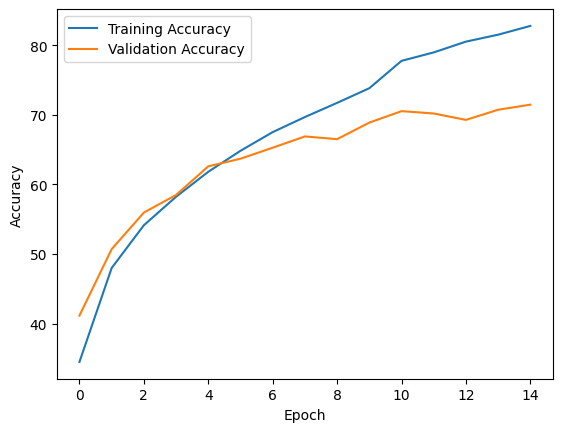

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the lists to store the losses and accuracies
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
num_epochs = 15

learning_rate = 0.01  # Adjust the learning rate manually
gamma = 0.5  # Adjust the gamma manually
step_size = 10  # Adjust the step size manually

model = CNN().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model using the specified hyperparameters
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc.append(100 * correct / total)

    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_acc.append(100 * correct / total)

    # Print epoch and losses
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss[-1]:.4f}, Training Acc: {train_acc[-1]:.4f}, "
          f"Val Loss: {valid_loss[-1]:.4f}, Validation Acc: {valid_acc[-1]:.4f}")

# Plot the loss and accuracy over epochs
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()